In [8]:
import torch
import torch.fft as fft

Array = torch.Tensor

from torch_cfd.grids import *
from torch_cfd.equations import *
from torch_cfd.initial_conditions import *
from torch_cfd.finite_differences import *
from torch_cfd.forcings import *

import xarray
import seaborn as sns
from tqdm.auto import tqdm

torch.set_default_dtype(torch.float64)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [13]:
n = 512
diam = 2 * torch.pi
dt = 1e-3
T = 1
num_steps = int(T / dt)
record_steps = 10
max_velocity = 7
peak_wavenumber = 4
scale = 1


grid = Grid(shape=(n, n), domain=((0, diam), (0, diam)), device=device)

v0 = filtered_velocity_field(grid, max_velocity, peak_wavenumber)

vort = curl_2d(v0).data
vort_hat = fft.rfft2(vort).to(device)

ns2d = NavierStokes2D(
    viscosity=1e-3, 
    grid=grid, drag=0.1, smooth=True, forcing_fn=kolmogorov_forcing
).to(device)


In [14]:
vort = []

with tqdm(total=num_steps) as pbar:
    for t in range(num_steps):
        vort_hat = crank_nicolson_rk4(ns2d, vort_hat, dt)

        if t % record_steps == 0:
            vort.append(vort_hat)
        pbar.update()

    vort = torch.stack(vort, dim=0)
    vort = fft.irfft2(vort).cpu().numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

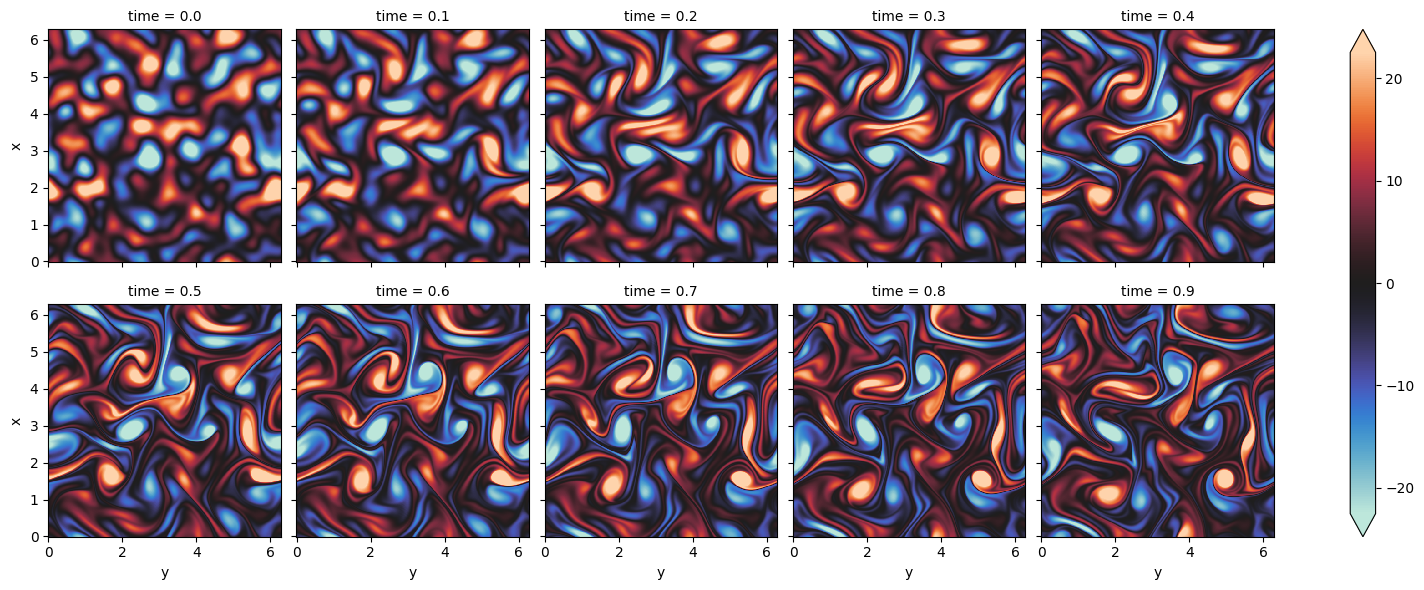

In [15]:
spatial_coord = torch.arange(grid.shape[0]) * 2 * torch.pi / grid.shape[0] # same for x and y
coords = {
  'time': 10* dt * torch.arange(100),
  'x': spatial_coord,
  'y': spatial_coord,
}

data = xarray.DataArray(
    vort,
    dims=["time", "x", "y"], 
    coords=coords)

data.thin(time=10).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);